# Convolutional AutoEncoder for denoising Cifar dataset

## Backend and Import

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

Using TensorFlow backend.


## Load Cifar10 dataset

In [3]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [8]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


## add noise to data

In [9]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

## show noisy images

In [16]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

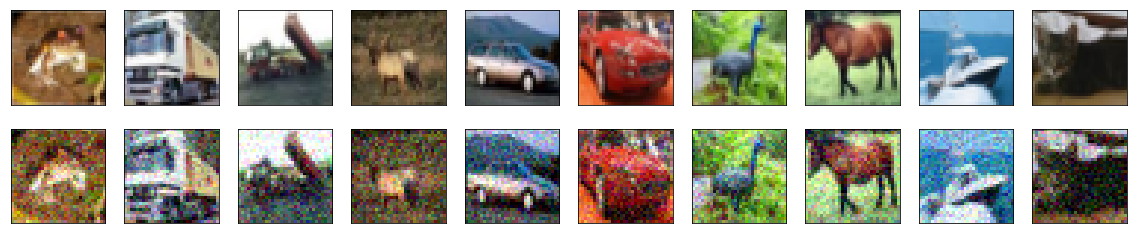

In [17]:
showOrigDec(x_train, x_train_noisy)

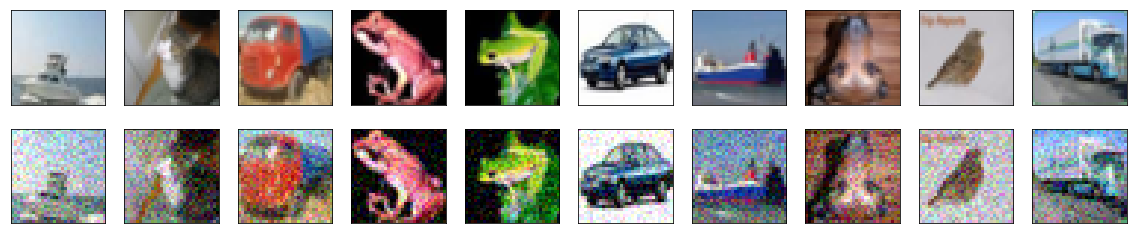

In [23]:
showOrigDec(x_train[100:], x_train_noisy[100:])

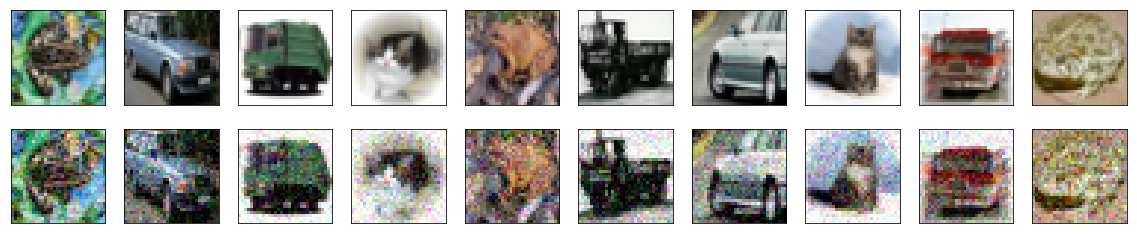

In [24]:
showOrigDec(x_train[200:], x_train_noisy[200:])

## Convolutional AutoEncoder for denoising

In [18]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [19]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

## Train AutoEncoder

In [35]:
# load pretrained weights
model.load_weights(saveDir + "AutoEncoder_Cifar10_denoise_weights.10-0.55-0.55.hdf5")

In [36]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_denoise_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [37]:
history = model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/100
50000/50000 [==============================] - 374s - loss: 0.5558 - val_loss: 0.5556
Epoch 2/100
50000/50000 [==============================] - 374s - loss: 0.5557 - val_loss: 0.5553
Epoch 3/100
50000/50000 [==============================] - 374s - loss: 0.5556 - val_loss: 0.5554
Epoch 4/100
50000/50000 [==============================] - 374s - loss: 0.5556 - val_loss: 0.5555
Epoch 5/100
50000/50000 [==============================] - 374s - loss: 0.5555 - val_loss: 0.5552
Epoch 6/100
50000/50000 [==============================] - 374s - loss: 0.5555 - val_loss: 0.5553
Epoch 7/100
50000/50000 [==============================] - 375s - loss: 0.5554 - val_loss: 0.5553
Epoch 8/100
50000/50000 [==============================] - 375s - loss: 0.5555 - val_loss: 0.5554
Epoch 00007: early stopping


## Evaluate with test dataset

In [38]:
score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)

3000/3000 [==============================] - 8s     
0.554736315886


## Visualize original image, noisy image and denoised image

In [43]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [44]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.4845075011253357
Cifar10_val: 0.48806482553482056


In [47]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

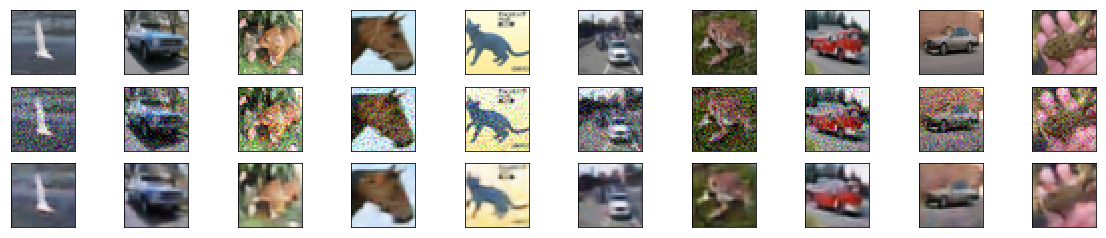

In [48]:
showOrigDec(x_test, x_test_noisy, c10test)

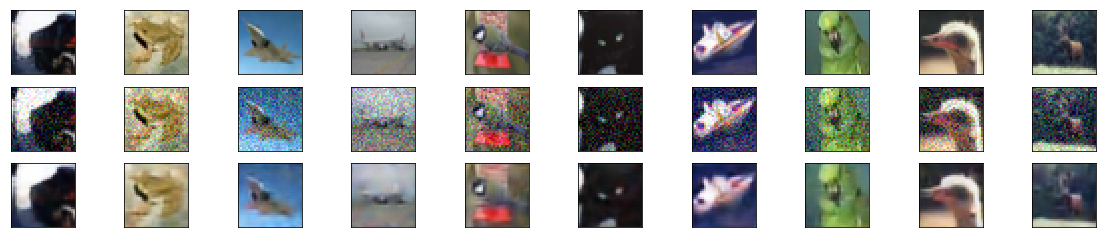

In [61]:
showOrigDec(x_test[100:], x_test_noisy[100:], c10test[100:])

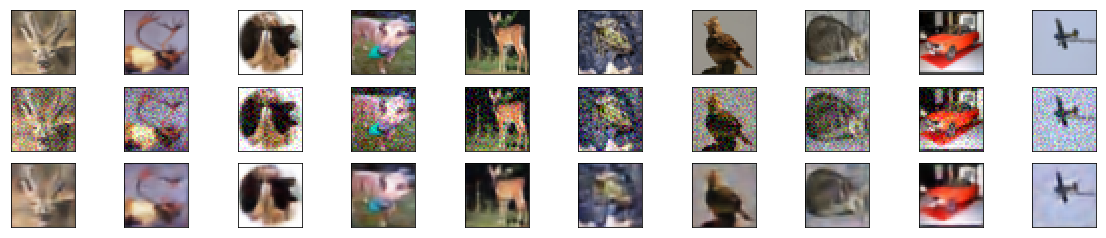

In [62]:
showOrigDec(x_test[200:], x_test_noisy[200:], c10test[200:])

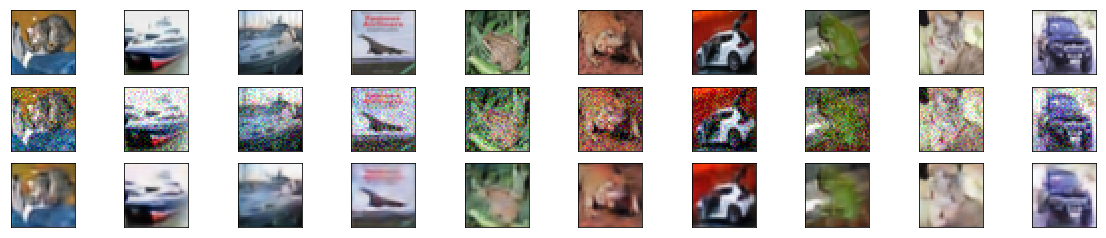

In [49]:
showOrigDec(x_val, x_val_noisy, c10val)

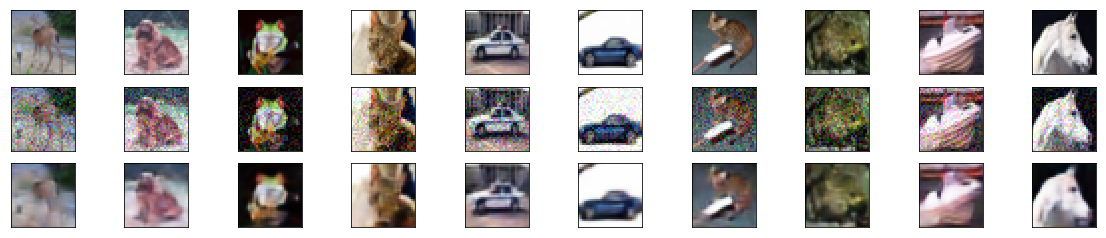

In [63]:
showOrigDec(x_val[100:], x_val_noisy[100:], c10val[100:])

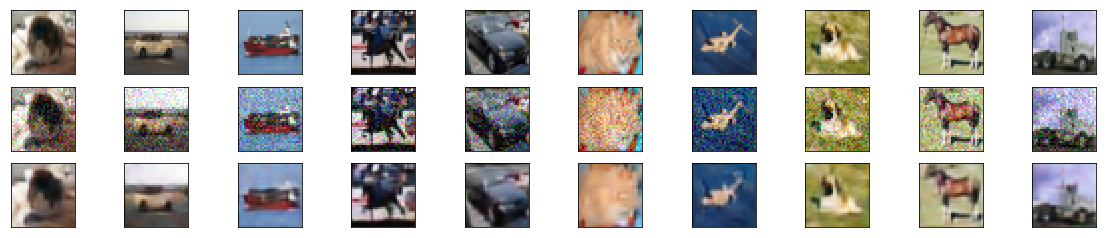

In [64]:
showOrigDec(x_val[200:], x_val_noisy[200:], c10val[200:])

## Try the Denoising AutoEncoder on Cifar100

## Load cifar100 dataset

In [50]:
from keras.datasets import cifar100

(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()

In [51]:
# normalize data
x_train100 = x_train100.astype('float32')
x_test100 = x_test100.astype('float32')
x_train100 /= 255
x_test100 /= 255

In [52]:
print('x_train100 shape:', x_train100.shape)
print(x_train100.shape[0], 'train samples')
print(x_test100.shape[0], 'test samples')

x_train100 shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## add noise to Cifar100 data

In [54]:
noise_factor = 0.1
x_train100_noisy = x_train100 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train100.shape) 
x_test100_noisy = x_test100 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test100.shape) 

x_train100_noisy = np.clip(x_train100_noisy, 0., 1.)
x_test100_noisy = np.clip(x_test100_noisy, 0., 1.)

In [55]:
score = model.evaluate(x_train100_noisy, x_train100_noisy, verbose=1)
print(score)

49984/50000 [============================>.] - ETA: 0s0.545567723141


In [56]:
score = model.evaluate(x_test100_noisy, x_test100_noisy, verbose=1)
print(score)

 9984/10000 [============================>.] - ETA: 0s0.544707490349


## Autoencoder on  Cifar100 dateset

In [57]:
c100train = model.predict(x_train100_noisy)
c100test = model.predict(x_test100_noisy)

In [58]:
print("Cifar100 train: {0} \nCifar100 test: {1}"
      .format(np.average(c100train), np.average(c100test)))

Cifar100 train: 0.48853644728660583 
Cifar100 test: 0.4897351562976837


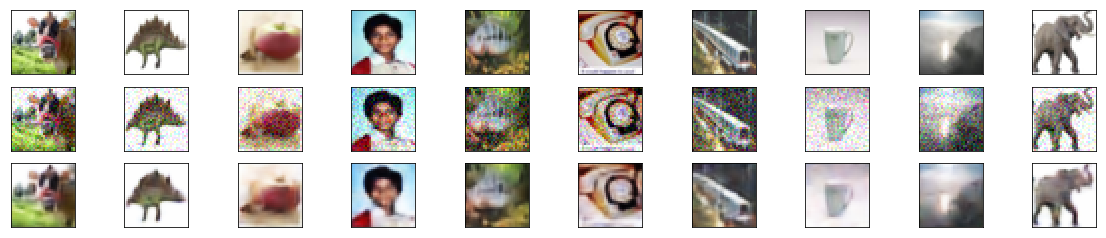

In [59]:
showOrigDec(x_train100, x_train100_noisy, c100train)

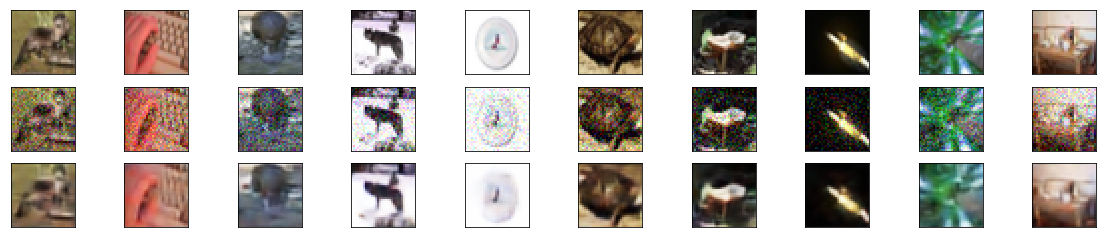

In [65]:
showOrigDec(x_train100[100:], x_train100_noisy[100:], c100train[100:])

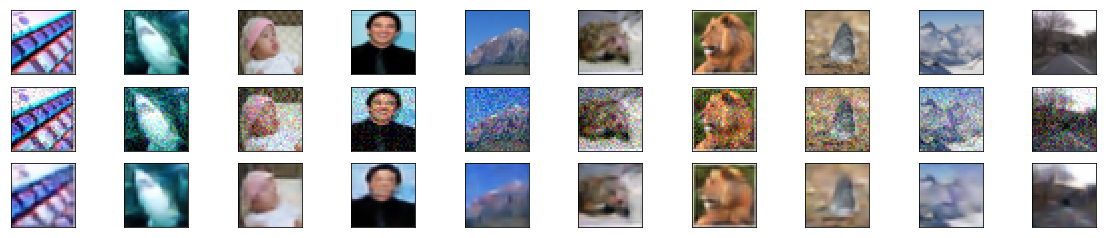

In [66]:
showOrigDec(x_train100[200:], x_train100_noisy[200:], c100train[200:])

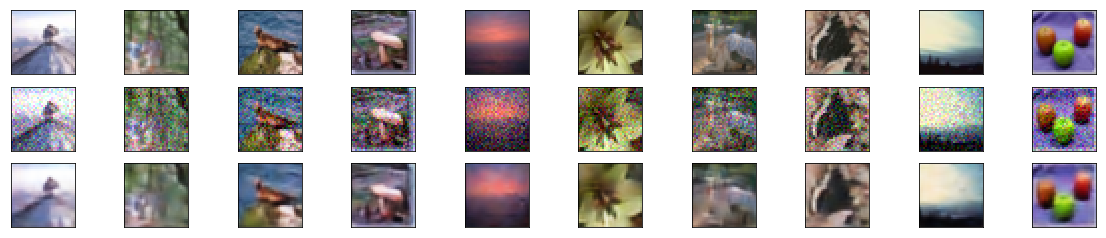

In [60]:
showOrigDec(x_test100, x_test100_noisy, c100test)

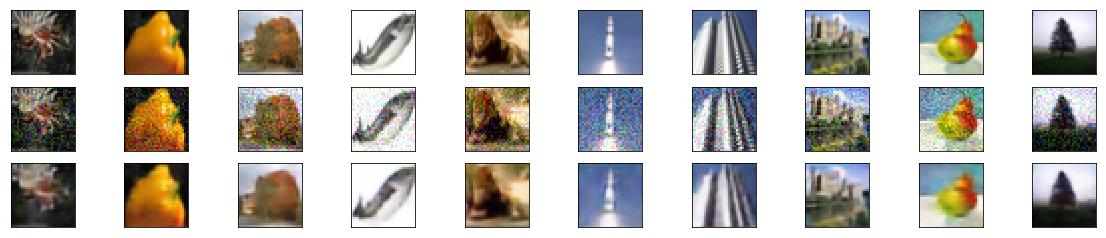

In [67]:
showOrigDec(x_test100[100:], x_test100_noisy[100:], c100test[100:])

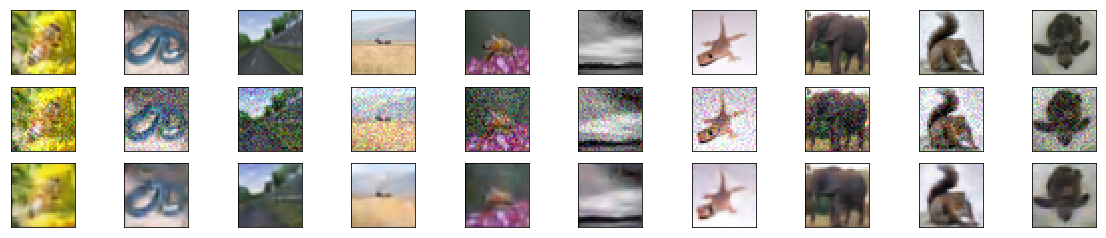

In [68]:
showOrigDec(x_test100[200:], x_test100_noisy[200:], c100test[200:])